In [160]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from time import time, sleep
%load_ext line_profiler

## Some general concepts: map and reduce


### Map
A map is essentially a function that takes some input, and produces some output (as most functions do), thus mapping from an input space to an output space.

Python provides a built-in function called `map` which applies another function to a list of arguments. Note that this is shown here mainly as an example of the concept of mapping from input to output, not because it is a particularly good idea to use `map`. You can usually find more readable ways to do the same.

### Reduce
A reduction uses an associative operation (associative means order of operands doesn't matter) to reduce a list of inputs to a single value. Common examples include taking the sum of a list of numbers, or a product of a list of numbers.

Python provides a function called `reduce` from the module `functools`. It takes a binary function (a function of two arguments), and applies it repeatedly to a list of inputs until one one value remains. Again, I include this here mainly as an example of the concept of reducing a list of inputs, not because it is a particularly good idea to use `reduce`. You can usually find more readable ways to do the same.

### MapReduce
Problems that can be formulated as a mapping and a reduction can sometimes be parallelised efficiently. The idea is that the mapping part, which usually takes the most time, can be distributed across processors, or even across different machines on a network, while the reduction part is usually fast, and since a reduction uses an associative operation, it doesn't matter in what order the results of the mapping are ready.

An example might be that you analyse a set of images from an experiment, where you only care about the total number of particles seen in all the images. The mapping operation takes an image as input, and produces a single number (the particle count) as output. The reduction then just consists of keeping a running total of the counts when they are ready.

In [2]:
def doubler(x):
    return 2*x

inputs = np.arange(10)

# Produce list of outputs using map
# (map returns an iterable, not a list, so converting explicitly)
outputs = list(map(doubler, inputs))
print(outputs)

# Produce the same list of outputs using list comprehension
outputs = [doubler(x) for x in inputs]
print(outputs)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
from functools import reduce 
from operator import add

# The add function is equivalent to '+', but in function form.
print(5+5)
print(add(5,5))

# The add function takes exactly two arguments
# add(5)
add(5, 5, 5)

10
10


TypeError: op_add expected 2 arguments, got 3

In [4]:
inputs = np.arange(10)

# Apply the add operator to the list of inputs
total = reduce(add, inputs)
print(f'Total = {total}')

# You can achieve the same with the built-in sum function
total = sum(inputs)
print(f'Total = {total}')

Total = 45
Total = 45


## Launching several copies of a Python script from another script or notebook

There are many different ways to launch multiple copies of a python script (or other program, for that matter). I you just need to run a few simulations, for a few different parameters, it might be easiest to just launch them manually. For more simulations, or if you want to run systematically for a range of input parameters, it might make more sense to set up some scheme for automatically launching simulations. Shell script can be a good tool for this, or you can launch other programs from a Python program with the `subprocess` library. Note that this can be used to launch any program, not just other Python programs.

In [5]:
import subprocess

In [6]:
subprocesses = []
for i in range(4):
    # start 4 identical copies of the program, and add to list
    # note that we could also give them different command line
    # arguments by adding more entries in the list of args
    # (note that arguments must be strings, not numbers)
    args = ['python', '../Python/Parallelisation/wait.py', str(i)]
    subprocesses.append( subprocess.Popen(args) )
    
print('All processes launched')


# Wait for all copies to finish before proceeding.
# p.wait() does not return until the subprocess is complete.
for p in subprocesses:
    p.wait()
    
print('All processes completed')

All processes launched
All processes completed


## Keeping all CPUs busy while running a large number of jobs

If you need to run a large number of simulations, it usually makes sense to try to keep all CPUs busy. Say you have 4 CPU cores, then you might want to launch 4 simulations, and as soon as one is finished, you launch another. On Mac and Linux, you can achieve this with the command line tool `xargs` (which I believe is also awailable of modern Windows installations with the Windows subsystem for Linux: https://en.wikipedia.org/wiki/Windows_Subsystem_for_Linux ).

However, you might also want to write a python script to do the same thing, since this makes it easy to run simulations for different parameter values.

In [7]:
# parameters to run simulation for
parameters = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
# Max simultaneous runs
Nprocs = 4

# List to keep track of launched processes
subprocesses = []
# Number currently running
running = 0

while len(subprocesses) < len(parameters):
    # Check if number of simulations currently running
    # is smaller than number of processors
    if running < Nprocs:
        # Start a simulation
        i = len(subprocesses)
        args = ['python', '../Python/Parallelisation/wait.py', str(parameters[i])]
        subprocesses.append( subprocess.Popen(args))
    else:
        # Wait a few seconds before checking again
        sleep(2)
        
    # Count number of running processes, by creating a boolean
    # array with True for running processes and False for completed
    # p.poll() returns None if p is still running,
    # and 0 if it has excited successfully
    running = sum([p.poll() is None for p in subprocesses])
    print(f'{running} subprocesses running')

print('All processes launched')


# Wait for all copies to finish before proceeding.
# p.wait() does not return until the subprocess is complete.
for p in subprocesses:
    p.wait()
    
print('All processes completed')

1 subprocesses running
2 subprocesses running
3 subprocesses running
4 subprocesses running
4 subprocesses running
4 subprocesses running
0 subprocesses running
1 subprocesses running
2 subprocesses running
3 subprocesses running
4 subprocesses running
4 subprocesses running
4 subprocesses running
0 subprocesses running
1 subprocesses running
2 subprocesses running
All processes launched
All processes completed


## Running multiple copies of a function with the Multiprocessing module

In [8]:
from multiprocessing import Process, Pool

# For reasons that are not entirely clear to me,
# the multiprocessing module seems to have trouble
# with functions defined in a notebook. Therefore,
# I have defined a function in a separate file
# called wait_function.py, which I import here.
import sys
sys.path.append('../Python/Parallelisation/')
import example_functions

In [9]:
# List of inputs for which to run simulation
parameters = np.arange(12)

processes = []

for x in parameters:
    # the function is defined in the file wait_function.py,
    # see comments above
    p = Process(target = example_functions.wait_function, args = (x, ))
    p.start()
    processes.append(p)

# Wait for all copies to finish before proceeding.
# p.join() does not return until the process is complete.
for p in processes:
    p.join()

This is wait_function, x = 0, sleeping a few seconds...
This is wait_function, x = 1, sleeping a few seconds...
This is wait_function, x = 2, sleeping a few seconds...
This is wait_function, x = 3, sleeping a few seconds...
This is wait_function, x = 4, sleeping a few seconds...
This is wait_function, x = 5, sleeping a few seconds...
This is wait_function, x = 6, sleeping a few seconds...
This is wait_function, x = 7, sleeping a few seconds...
This is wait_function, x = 8, sleeping a few seconds...
This is wait_function, x = 9, sleeping a few seconds...
This is wait_function, x = 10, sleeping a few seconds...
This is wait_function, x = 11, sleeping a few seconds...


In [10]:
# List of inputs for which to run simulation
parameters = np.arange(12)

# Using a pool of 4 processes will keep
# 4 copies of the function running at all times,
# until the function has been run for each parameter
with Pool(4) as pool:
    pool.map(example_functions.wait_function, parameters)

This is wait_function, x = 1, sleeping a few seconds...
This is wait_function, x = 0, sleeping a few seconds...
This is wait_function, x = 2, sleeping a few seconds...
This is wait_function, x = 3, sleeping a few seconds...
This is wait_function, x = 4, sleeping a few seconds...
This is wait_function, x = 6, sleeping a few seconds...
This is wait_function, x = 5, sleeping a few seconds...
This is wait_function, x = 7, sleeping a few seconds...
This is wait_function, x = 8, sleeping a few seconds...
This is wait_function, x = 9, sleeping a few seconds...
This is wait_function, x = 10, sleeping a few seconds...
This is wait_function, x = 11, sleeping a few seconds...


## Parallelisation with Numba

Numba has some support for parallelisation. For example you can parallelise loops by using `prange` instead of `range`. Note that this requires that each iteration in the loop is indpenedent of the other iterations.

For additional information, see the Numba documentation: https://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel

In [15]:
from numba import jit, prange

In [12]:
@jit(nopython = True)
def iterator(z, c, maxiter):
    for i in range(maxiter):
        z = z*z + c
        if abs(z) > 2:
            return i
    return maxiter

@jit(nopython = True)
def julia_serial(c, Nx, Ny, xmin=-1.5, xmax=1.5, ymin=-1., ymax=1., maxiter=100):
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    m = np.empty((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            m[i,j] = iterator(z = x[i] + 1j*y[j], c = c, maxiter = maxiter)
    return x, y, m

@jit(nopython = True, parallel = True)
def julia_parallel(c, Nx, Ny, xmin=-1.5, xmax=1.5, ymin=-1., ymax=1., maxiter=100):
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    m = np.empty((Nx, Ny))
    # Note use of prange instead of range
    # (requires parallel = True in the @jit decorator)
    for i in prange(Nx):
        for j in range(Ny):
            m[i,j] = iterator(z = x[i] + 1j*y[j], c = c, maxiter = maxiter)
    return x, y, m

# Force compilation by calling functions here,
# to avoid messing up timing later
_ = julia_serial(0+1j, 1, 1)
_ = julia_parallel(0+1j, 1, 1)

In [13]:
Nx = 1500
Ny = 1000
c = 0.02 + 1j*0.4

print('Serial version:')
%timeit -n1 -r5 x, y, m = julia_serial(c, Nx, Ny)

print('Parallel version:')
%timeit -n1 -r5 x, y, m = julia_parallel(c, Nx, Ny)

Serial version:
944 ms ± 17.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
Parallel version:
187 ms ± 12.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [14]:
@jit(nopython=True)
def diffusion_serial(C0, D, v, X, T):
    # Make a copy to avoid overwriting the initial condition
    C = C0.copy()
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        # Make a new empty array to hold the updated values
        Cnew = np.empty_like(C)
        # Using a for-loop to begin with
        # Handle interior points first
        for i in range(1, len(C)-1):
            Cnew[i] = C[i] + dt*(D*(C[i+1] - 2*C[i] + C[i-1])/dx**2  -  v*(C[i+1] - C[i-1])/(2*dx))
        # Then, handle boundary points to get periodic BC
        Cnew[ 0] = C[ 0] + dt*(D*(C[1] - 2*C[ 0] + C[-1])/dx**2  -  v*(C[1] - C[-1])/(2*dx))
        Cnew[-1] = C[-1] + dt*(D*(C[0] - 2*C[-1] + C[-2])/dx**2  -  v*(C[0] - C[-2])/(2*dx))
        # Finally, copy values back into C
        C = Cnew
    # Return results at
    return C

@jit(nopython=True, parallel = True)
def diffusion_parallel(C0, D, v, X, T):
    # Make a copy to avoid overwriting the initial condition
    C = C0.copy()
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        # Make a new empty array to hold the updated values
        Cnew = np.empty_like(C)
        # Using a for-loop to begin with
        # Handle interior points first
        # Note use of prange instead of range here
        for i in prange(1, len(C)-1):
            Cnew[i] = C[i] + dt*(D*(C[i+1] - 2*C[i] + C[i-1])/dx**2  -  v*(C[i+1] - C[i-1])/(2*dx))
        # Then, handle boundary points to get periodic BC
        Cnew[ 0] = C[ 0] + dt*(D*(C[1] - 2*C[ 0] + C[-1])/dx**2  -  v*(C[1] - C[-1])/(2*dx))
        Cnew[-1] = C[-1] + dt*(D*(C[0] - 2*C[-1] + C[-2])/dx**2  -  v*(C[0] - C[-2])/(2*dx))
        # Finally, copy values back into C
        C = Cnew
    # Return results at
    return C

# Force compilation by calling functions here,
# to avoid messing up timing later
_ = diffusion_serial(np.linspace(0,1,10), 1e-3, 1e-3, np.linspace(0, 1, 10), np.linspace(0, 1, 10))
_ = diffusion_parallel(np.linspace(0,1,10), 1e-3, 1e-3, np.linspace(0, 1, 10), np.linspace(0, 1, 10))

In [15]:
# Set up and run simulation
D = 0.0001 # Diffusivity
v = 0.01 # Advection velocity
T = np.linspace(0, 1, 20001) # time coordinates
X = np.linspace(0, 1, 10001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

print('Serial version:')
%timeit -n1 -r3 C = diffusion_serial(C0, D, v, X, T)

print('Parallel version:')
%timeit -n1 -r3 C = diffusion_parallel(C0, D, v, X, T)

D dt/dx**2 = 0.5000
Serial version:
2.62 s ± 53.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Parallel version:
750 ms ± 21.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## GPU parallelisation (Cuda) with numba

GPU parallelisation takes advantage of the graphics processor, which can accelerate some tasks. A few points to keep in mind:
* GPUs typically have a large number of cores (several thousand in high-end GPUs)
* GPUs typically have a limited amount of memory per core (often around 10 MB/core, compared to several GB/core for a typical laptop CPU)
* GPUs might not support double precision (or only supported with reduced performance)
* Data must be transfered from the main memory of the computer to the GPU memory before computations start, and back again afterwards.

In summary, this means that GPU parallelisation is extremely well suited to some tasks, and not at all suited to other tasks. The best problems are those where there is not too much memory required, and the problem can be split into very many small and independent sub-problems. A typical use case is where you have an array of data, and you want to perform some operation on the array, where the operation on each element is independent of the operations on the other elements. To run code on the GPU, you will typically write a so-called "kernel", which is essentially a function that runs on the GPU. The kernel is executed on each core (of which there may be thousands), and operates on a small part, or even a single element, of the input array.

Numba provides support for GPU parallelisation with Cuda. This requires that you have an Nvidia GPU, and that you have Cuda drivers already installed. Experimental support for AMD GPUs is also available.

See the documentation for further details: https://numba.pydata.org/numba-doc/dev/user/index.html

In [166]:
from numba import cuda, vectorize, float32, float64, int32, complex64

# print the name of the device
cuda.gpus.lst[0]._device.name

b'GeForce GTX 1080 Ti'

### Example: Parallel Mandelbrot set with GPU

In [75]:
@vectorize('int32(complex64)')
def mandelbrot_cpu(c):
    maxiter = 100
    z = 0.0 + 0*1j
    for i in range(maxiter):
        z = z*z + c
        if abs(z) > 2:
            return i
    return maxiter

@vectorize('int32(complex64)', target ='cuda')
def mandelbrot_gpu(c):
    maxiter = 100
    z = 0.0 + 0*1j
    for i in range(maxiter):
        z = z*z + c
        if abs(z) > 2:
            return i
    return maxiter

# Call both functions once to force compilation here
c = np.complex64(0 + 1j)
_ = mandelbrot_cpu(c)
_ = mandelbrot_gpu(c)

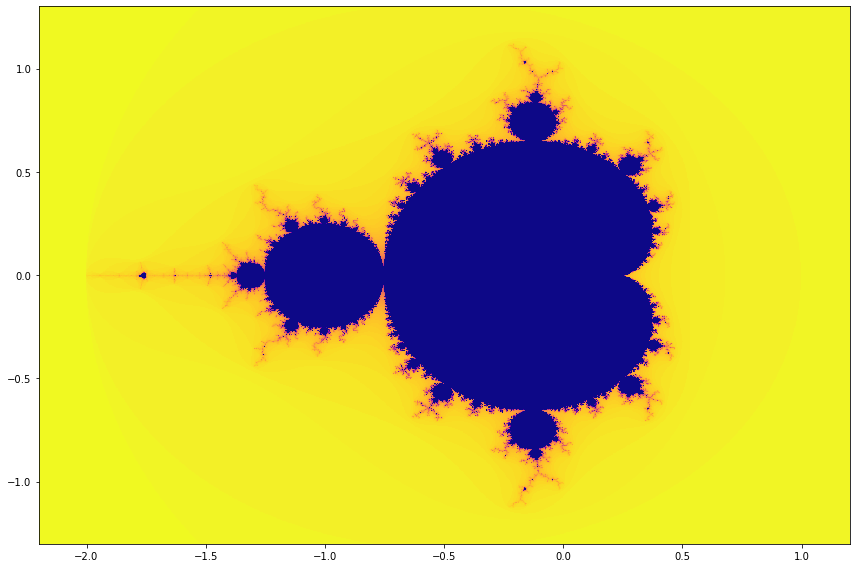

In [76]:
Nx, Ny = 1500, 1000
xmin, xmax = -2.2, 1.2
ymin, ymax = -1.3, 1.3
x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)

C = (x[:,None] + 1j*y[None,:]).astype(np.complex64)

M = mandelbrot_gpu(C)

fig = plt.figure(figsize = (12, 8))
plt.pcolormesh(x, y, M.T, shading = 'auto', cmap = 'plasma_r')
plt.tight_layout()

In [77]:
print('CPU version:')
%timeit M = mandelbrot_cpu(C)

print('GPU version')
%timeit M = mandelbrot_gpu(C)

CPU version:
421 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPU version
10.6 ms ± 65.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Example: 2D Diffusion equation on GPU

In [362]:
#@cuda.jit('(float32[:,:], float32[:,:], float32, float32, float32)')
@cuda.jit('(float64[:,:], float64[:,:], float64, float64, float64)')
def FTCS_gpu(C_now, C_next, D, dt, dx):
    # Get array bounds
    Nx, Ny = C_now.shape
    # Get the cell of this thread
    i, j = cuda.grid(2)
    # First, check that i and j are within bounds
    if ((0 <= i) and (i < Nx)) and ((0 <= j) and (j < Ny)):
        # Then, update this cell, using division modulo Nx and Ny
        # implement periodic boundary conditions
        alpha =  D*dt/dx**2
        C_next[i,j] = C_now[i,j] + alpha*(
             C_now[(i+1)%Nx, j]
            +C_now[(i-1)%Nx, j] 
            +C_now[i, (j+1)%Ny] 
            +C_now[i, (j-1)%Ny]
            -4*C_now[i,j]
        )
        
def diffusion_solver_gpu(C0, D, Tmax, dt, dx):
    # Define working precision
    WP = np.float64
    # Create two arrays on the GPU, of the desired precision
    d_C_now = cuda.to_device(C0.astype(WP))
    d_C_next = cuda.device_array_like(C0.astype(WP))
    # Make copies of parameters in working precision
    d_D  = WP(D)
    d_dt = WP(dt)
    d_dx = WP(dx)
    
    # Number of threads per block
    threads = (32, 32)
    # Calculate number of blocks needed to match size of array
    Nx, Ny = C0.shape
    blocks = (
        int(Nx/threads[0]) if Nx%threads[0] == 0 else int(Nx/threads[0])+1,
        int(Ny/threads[1]) if Ny%threads[1] == 0 else int(Ny/threads[1])+1,
    )
    
    # Then, loop over time
    Nt = int(Tmax/dt)
    for i in range(Nt):
        # One iteration with the FTCS method
        FTCS_gpu[blocks, threads](d_C_now, d_C_next, d_D, d_dt, d_dx)
        # Then update arrays
        d_C_now = d_C_next
    
    # Copy results back to main memory
    C = d_C_now.copy_to_host()
    
    return C


def diffusion_solver_cpu(C0, D, Tmax, dt, dx):
    # Work arrays
    C_now = C0.copy()
    C_next = np.zeros_like(C0)
    # Prefactor
    alpha =  D*dt/dx**2
    # Loop over time
    Nt = int(Tmax/dt)
    for i in range(Nt):
        # One iteration with the FTCS method
        # Interior points
        C_next[1:-1, 1:-1] = C_now[1:-1, 1:-1] + alpha*(
             C_now[2:  , 1:-1]
            +C_now[ :-2, 1:-1]
            +C_now[1:-1, 2:  ]
            +C_now[1:-1,  :-2]
            -4*C_now[1:-1, 1:-1]
        )
        # Boundaries (periodic BC)
        C_next[ 0, 1:-1] = C_now[ 0, 1:-1] + alpha*(C_now[1, 1:-1]+C_now[-1, 1:-1]+C_now[ 0, 2:]+C_now[ 0, :-2]-4*C_now[ 0, 1:-1])
        C_next[-1, 1:-1] = C_now[-1, 1:-1] + alpha*(C_now[0, 1:-1]+C_now[-2, 1:-1]+C_now[-1, 2:]+C_now[-1, :-2]-4*C_now[-1, 1:-1])
        C_next[1:-1,  0] = C_now[1:-1,  0] + alpha*(C_now[2:, 0]+C_now[:-2,  0]+C_now[1:-1, 1]+C_now[1:-1, -1]-4*C_now[1:-1,  0])
        C_next[1:-1, -1] = C_now[1:-1, -1] + alpha*(C_now[2:,-1]+C_now[:-2, -1]+C_now[1:-1, 0]+C_now[1:-1, -2]-4*C_now[1:-1, -1])
        # Corners (periodic BC)
        C_next[ 0, 0] = C_now[ 0, 0] + alpha*(C_now[1, 0]+C_now[-1, 0]+C_now[ 0, 1]+C_now[ 0,-1]-4*C_now[ 0, 0])
        C_next[-1, 0] = C_now[-1, 0] + alpha*(C_now[0, 0]+C_now[-2, 0]+C_now[-1, 1]+C_now[-1,-1]-4*C_now[-1, 0])
        C_next[ 0,-1] = C_now[ 0,-1] + alpha*(C_now[1,-1]+C_now[-1,-1]+C_now[ 0, 0]+C_now[ 0,-2]-4*C_now[ 0,-1])
        C_next[-1,-1] = C_now[-1,-1] + alpha*(C_now[0,-1]+C_now[-2,-1]+C_now[-1, 0]+C_now[-1,-2]-4*C_now[-1,-1])
        
        C_now = C_next
    
    return C_now

In [363]:
# System parameters
Lx = 2
Ly = 1
Nx = 1024
Ny = 512
# Timestep
dt = 0.001
Tmax = 3

# Coordinates
xc, dx = np.linspace(0, Lx, Nx, retstep = True)
yc, dy = np.linspace(0, Ly, Ny, retstep = True)
# Grid points
gridx, gridy = np.meshgrid(xc, yc)

# Diffusivity (constant in space and time)
D = 0.0009

# Check stability condition for this method
print(f'D*dt/dx**2 = {D*dt/dx**2:.5f}, must be less than 0.25')

# Initial concentration (gaussian)
x0, y0 = 1.87, 0.87
sx, sy = 0.05, 0.05
# Create concentration field
C0 = (np.exp(-(gridx - x0)**2/(2*sx**2) - (gridy-y0)**2/(2*sy**2)))

tic = time()
C_gpu = diffusion_solver_gpu(C0, D, Tmax, dt, dx)
toc = time()
print(f'GPU Calculation took {toc - tic:.4f} seconds')

tic = time()
C_cpu = diffusion_solver_cpu(C0, D, Tmax, dt, dx)
toc = time()
print(f'CPU Calculation took {toc - tic:.4f} seconds')

D*dt/dx**2 = 0.23547, must be less than 0.25
GPU Calculation took 0.3292 seconds
CPU Calculation took 13.5622 seconds


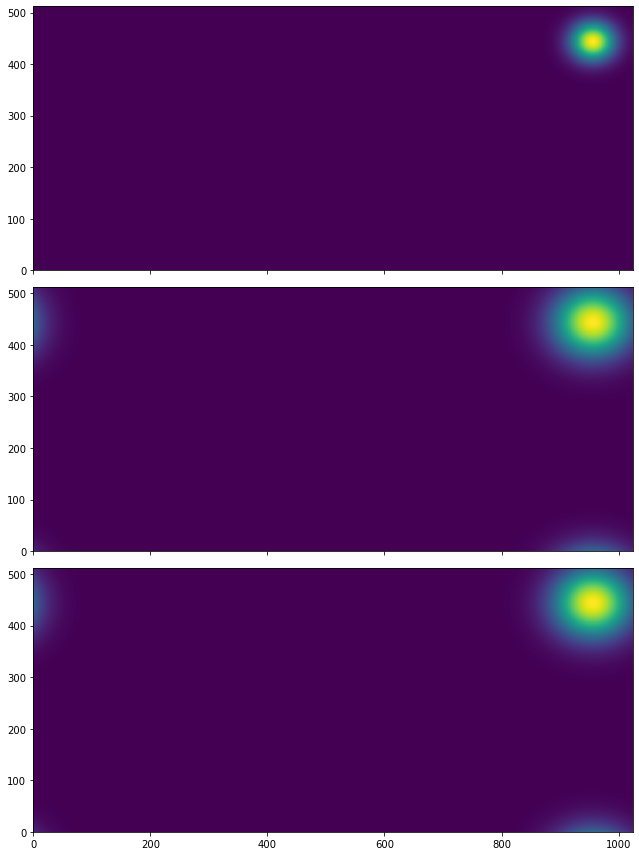

In [364]:
fig, ax = plt.subplots(nrows = 3, figsize = (9, 12), sharex = True, sharey = True)
ax[0].pcolormesh(C0)
ax[1].pcolormesh(C_cpu)
ax[2].pcolormesh(C_gpu)
plt.tight_layout()